### Calculate S04 index
Method adapted from Pinheiro et al. (2019). This uses four thresholds to apply for the blocking criterea, which are applied in turn:
    
    AMPLITUDE - count the number of grid squares exceeding the var threshold (which may be -ve or +ve if one looks at the anomalies or not)
    AREA - for each blocked region count the number of grid cells at each latitude and so calculate the total area of each blocked region
    PERSISTENCE - measure how long the block persists for, and set a threshold for at least five days
    OVERLAP - count the number of days over which the contours for the blocked region overlap

If all of these criterea are met, then blocked_day = True. Else blocked_day = False.
    
These thresholds are applied to two datasets: 500hPa geopotentiel height anomalies, detrended wrt surface temperature (creating a measure similar to Dole and Gordon (1983)) and the seasonal anomaly of vertically averaged potential vorticity (similar to Schweirz (2004)).  The calculation of the anomaly fields and detrending has been done in a separate notebook, and uses ``cdo`` commands: https://code.mpimet.mpg.de/projects/cdo/embedded/cdo.pdf

In [1]:
#import iris
import netCDF4 as nc
import xarray
import numpy as np
import scipy
from collections import OrderedDict 
#from windspharm.iris import VectorWind
from scipy.integrate import simps
import glob
import matplotlib.pyplot as plt
#import PDF_funcs
import cartopy.crs as ccrs
from scipy import stats
from itertools import groupby
from operator import itemgetter
#for mapping the polygon on a sphere to a polygon on a flat surface to calculate area
import pyproj
import math
from shapely import geometry
import collections
from shapely.geometry import Point
from matplotlib.path import Path
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
xarray.open_dataset("/rds/general/project/nowack_graven/live/carl/era5/10m_u_component_of_wind/ERA5_1997_10m_u_component_of_wind.nc")

<xarray.Dataset>
Dimensions:    (latitude: 181, longitude: 201, time: 736)
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.75 -9.5 -9.25 ... 39.5 39.75 40.0
  * latitude   (latitude) float32 75.0 74.75 74.5 74.25 ... 30.5 30.25 30.0
  * time       (time) datetime64[ns] 1997-06-01 ... 1997-08-31T21:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-28 17:21:50 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

Load the files that are necessary  - zg_dtrnd_areaweighted_DG83_varbool is the important file, which is the end output of section1 and used in section 2 to apply the area threshold to.

In [2]:
pv_avg_nolp=xarray.open_dataset("/rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_tot_ydayavg_timmean_nolp.nc")

In [13]:
Nov_arr = glob.glob("/rds/general/project/nowack_graven/live/carl/pv_era5/*comb*")
Dec_arr = glob.glob("/rds/general/project/nowack_graven/live/carl/pv_era5/*Dec*")

pv=xarray.open_dataset("/rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_Novcomb_0000.nc")



for mnth_str in Nov_arr[:]:
    time = mnth_str[-7:-3]
    print(f"time={time}")
    pv=xarray.open_dataset(mnth_str)
    pv.rename({'__xarray_dataarray_variable__': 'pv'}, inplace=True)
    #mnth_arr = [xarray.open_dataset(mnth_str)['pv_0001'].dropna('time'), xarray.open_dataset(mnth_str)['pv_0005'].dropna('time')]
    #mnth_arr_concat = xarray.concat(mnth_arr, "time")
    mnth_comstr = mnth_str[:-3] + "rn" + '.nc'
    print(f"mnth_comstr = {mnth_comstr}")
    pv.to_netcdf(mnth_comstr)
    
# for mnth_str in Dec_arr[:]:
#     time = mnth_str[-7:-3]
#     print(f"time={time}")
#     mnth_arr = [xarray.open_dataset(mnth_str)['pv_0001'].dropna('time'), xarray.open_dataset(mnth_str)['pv_0005'].dropna('time')]
#     mnth_arr_concat = xarray.concat(mnth_arr, "time")
#     mnth_comstr = mnth_str[:-8] + "comb_" + time + '.nc'
#     print(f"mnth_comstr = {mnth_comstr}")
#     mnth_arr_concat.to_netcdf(mnth_comstr)   
    

# for Dec in Dec_list:
#     test_arr = [xarray.open_dataset(Dec)['z_0001'][:,:,:].dropna('time'), xarray.open_dataset(Dec)['z_0005'][:,:,:].dropna('time')]
#     test_arr_concat = xarray.concat(test_arr, "time")
#     Dec_comstr = Dec[:-8] + "comb_" + time + '.nc'
#     print(f"Dec_comstr = {Dec_comstr}")
#     test_arr_concat.to_netcdf(Dec_comstr)

time=0600
mnth_comstr = /rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_Novcomb_0600rn.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  if sys.path[0] == '':


time=0000
mnth_comstr = /rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_Novcomb_0000rn.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  if sys.path[0] == '':


time=0900
mnth_comstr = /rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_Deccomb_0900rn.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  if sys.path[0] == '':


time=1500
mnth_comstr = /rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_Novcomb_1500rn.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  if sys.path[0] == '':


time=0300


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  if sys.path[0] == '':


mnth_comstr = /rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_Novcomb_0300rn.nc
time=2100
mnth_comstr = /rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_Deccomb_2100rn.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  if sys.path[0] == '':


time=0600
mnth_comstr = /rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_Deccomb_0600rn.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  if sys.path[0] == '':


time=1200
mnth_comstr = /rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_Deccomb_1200rn.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  if sys.path[0] == '':


time=0000
mnth_comstr = /rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_Deccomb_0000rn.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  if sys.path[0] == '':


time=1200


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  if sys.path[0] == '':


mnth_comstr = /rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_Novcomb_1200rn.nc
time=0900
mnth_comstr = /rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_Novcomb_0900rn.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  if sys.path[0] == '':


time=0300
mnth_comstr = /rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_Deccomb_0300rn.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  if sys.path[0] == '':


time=1500
mnth_comstr = /rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_Deccomb_1500rn.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  if sys.path[0] == '':


time=1800
mnth_comstr = /rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_Deccomb_1800rn.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  if sys.path[0] == '':


time=2100
mnth_comstr = /rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_Novcomb_2100rn.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  if sys.path[0] == '':


time=1800
mnth_comstr = /rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_Novcomb_1800rn.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  if sys.path[0] == '':


In [97]:
#!/bin/sh
mnth_str_arr = ["Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
cd /rds/general/project/carl_phd/live/carl/data/era5/day/pv/tot
for mnth in mnth_str_arr:
    print(f"cdo -b 32 mergetime *{mnth}* 500zg_1x1_1979-2019_{mnth}tot_3hr.nc")
    print(f"rm -f *_{mnth}_*")


# cdo -b 32 mergetime *Jan* pv_1x1_150-500hPa_1979-2019_Jan_3hr.nc &    
# cdo -b 32 mergetime *Feb* pv_1x1_150-500hPa_1979-2019_Feb_3hr.nc &    
# cdo -b 32 mergetime *Mar* pv_1x1_150-500hPa_1979-2019_Mar_3hr.nc &
# cdo -b 32 mergetime *Apr* pv_1x1_150-500hPa_1979-2019_Apr_3hr.nc &
# cdo -b 32 mergetime *May* pv_1x1_150-500hPa_1979-2019_May_3hr.nc &
# cdo -b 32 mergetime *Jun* pv_1x1_150-500hPa_1979-2019_Jun_3hr.nc &
# cdo -b 32 mergetime *Jul* pv_1x1_150-500hPa_1979-2019_Jul_3hr.nc &
# cdo -b 32 mergetime *Aug* pv_1x1_150-500hPa_1979-2019_Aug_3hr.nc &
# cdo -b 32 mergetime *Sep* pv_1x1_150-500hPa_1979-2019_Sep_3hr.nc &
# cdo -b 32 mergetime *Oct* pv_1x1_150-500hPa_1979-2019_Oct_3hr.nc &
# cdo -b 32 mergetime *Nov* pv_1x1_150-500hPa_1979-2019_Nov_3hr.nc &
# cdo -b 32 mergetime *Dec* pv_1x1_150-500hPa_1979-2019_Dec_3hr.nc &



cdo -b 32 mergetime *Feb* 500zg_1x1_1979-2019_Febtot_3hr.nc
rm -f *_Feb_*
cdo -b 32 mergetime *Mar* 500zg_1x1_1979-2019_Martot_3hr.nc
rm -f *_Mar_*
cdo -b 32 mergetime *Apr* 500zg_1x1_1979-2019_Aprtot_3hr.nc
rm -f *_Apr_*
cdo -b 32 mergetime *May* 500zg_1x1_1979-2019_Maytot_3hr.nc
rm -f *_May_*
cdo -b 32 mergetime *Jun* 500zg_1x1_1979-2019_Juntot_3hr.nc
rm -f *_Jun_*
cdo -b 32 mergetime *Jul* 500zg_1x1_1979-2019_Jultot_3hr.nc
rm -f *_Jul_*
cdo -b 32 mergetime *Aug* 500zg_1x1_1979-2019_Augtot_3hr.nc
rm -f *_Aug_*
cdo -b 32 mergetime *Sep* 500zg_1x1_1979-2019_Septot_3hr.nc
rm -f *_Sep_*
cdo -b 32 mergetime *Oct* 500zg_1x1_1979-2019_Octtot_3hr.nc
rm -f *_Oct_*
cdo -b 32 mergetime *Nov* 500zg_1x1_1979-2019_Novtot_3hr.nc
rm -f *_Nov_*
cdo -b 32 mergetime *Dec* 500zg_1x1_1979-2019_Dectot_3hr.nc
rm -f *_Dec_*


In [59]:
Nov_list=sorted(glob.glob("/rds/general/project/carl_phd/live/carl/data/era5/day/zg/tot/*500zg_1x1_1979-2019_Nov_*"))
Dec_list=sorted(glob.glob("/rds/general/project/carl_phd/live/carl/data/era5/day/zg/tot/*500zg_1x1_1979-2019_Dec_*"))

In [66]:
for Dec in Dec_list:
    time = Dec[-7:-3]
    print(f"time={time}")
    test_arr = [xarray.open_dataset(Dec)['z_0001'][:,:,:].dropna('time'), xarray.open_dataset(Dec)['z_0005'][:,:,:].dropna('time')]
    test_arr_concat = xarray.concat(test_arr, "time")
    Dec_comstr = Dec[:-8] + "comb_" + time + '.nc'
    print(f"Dec_comstr = {Dec_comstr}")
    test_arr_concat.to_netcdf(Dec_comstr)

time=0000
Dec_comstr = /rds/general/project/carl_phd/live/carl/data/era5/day/zg/tot/500zg_1x1_1979-2019_Deccomb_0000.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/xarray/coding/times.py:244: FutureWarning: the 'box' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'box'
  dates = pd.to_datetime(dates, box=False)


time=0300
Dec_comstr = /rds/general/project/carl_phd/live/carl/data/era5/day/zg/tot/500zg_1x1_1979-2019_Deccomb_0300.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/xarray/coding/times.py:244: FutureWarning: the 'box' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'box'
  dates = pd.to_datetime(dates, box=False)


time=0600
Dec_comstr = /rds/general/project/carl_phd/live/carl/data/era5/day/zg/tot/500zg_1x1_1979-2019_Deccomb_0600.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/xarray/coding/times.py:244: FutureWarning: the 'box' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'box'
  dates = pd.to_datetime(dates, box=False)


time=0900
Dec_comstr = /rds/general/project/carl_phd/live/carl/data/era5/day/zg/tot/500zg_1x1_1979-2019_Deccomb_0900.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/xarray/coding/times.py:244: FutureWarning: the 'box' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'box'
  dates = pd.to_datetime(dates, box=False)


time=1200
Dec_comstr = /rds/general/project/carl_phd/live/carl/data/era5/day/zg/tot/500zg_1x1_1979-2019_Deccomb_1200.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/xarray/coding/times.py:244: FutureWarning: the 'box' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'box'
  dates = pd.to_datetime(dates, box=False)


time=1500
Dec_comstr = /rds/general/project/carl_phd/live/carl/data/era5/day/zg/tot/500zg_1x1_1979-2019_Deccomb_1500.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/xarray/coding/times.py:244: FutureWarning: the 'box' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'box'
  dates = pd.to_datetime(dates, box=False)


time=1800
Dec_comstr = /rds/general/project/carl_phd/live/carl/data/era5/day/zg/tot/500zg_1x1_1979-2019_Deccomb_1800.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/xarray/coding/times.py:244: FutureWarning: the 'box' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'box'
  dates = pd.to_datetime(dates, box=False)


time=2100
Dec_comstr = /rds/general/project/carl_phd/live/carl/data/era5/day/zg/tot/500zg_1x1_1979-2019_Deccomb_2100.nc


/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/xarray/coding/times.py:244: FutureWarning: the 'box' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'box'
  dates = pd.to_datetime(dates, box=False)


In [27]:
test_arr=[xarray.open_dataset("/rds/general/project/carl_phd/live/carl/data/era5/day/pv/tot/pv_1x1_150-500hPa_1979-2019_Nov_0000.nc")['pv_0001'][:,0,0,0].dropna('time'),
          xarray.open_dataset("/rds/general/project/carl_phd/live/carl/data/era5/day/pv/tot/pv_1x1_150-500hPa_1979-2019_Nov_0000.nc")['pv_0005'][:,0,0,0].dropna('time') ]
#concatenate the set of xarrays created above - also takes a few seconds
test_arr_concat = xarray.concat(test_arr, "time")

In [40]:
#implelemnt the amplitude criterea (as above but normalised for when the file is loaded again)
#this is the file that is used from the rest of the notebook to implement the other blocking criterea
zg_dtrnd_areaweighted_DG83_varbool=xarray.open_dataset("/rds/general/project/carl_phd/live/carl/data/era5/day/zg/"
                                            "500zg_JJA_era5_1979-2019_daymean_EurAR5_1x1_anom_dtrnd_wrt_tas_DG83_bool.nc")['500zg']

These are the variables used below; the definitions here are adapted from P19, but can be changed if desired.

In [31]:
persis_thresh = 5 # number of days over which blocking persists
JJA_days = 92
# overlap_val = minimum number of cells needed to say if there is overlap between two blocked regions
# set to 1 by default - any overlap between contours is acceptable
#may want to change depending on spatial and temporal resolution
overlap_val = 1

amp_thresh=1e-6 # following Schweirz et al 2004, who limited spatial resolution to 100 m
amp_thresh_anom=-1.2e-6 #threshold for a low VPV value for anomaly data

amp_min_anom_thresh = 100

area_thresh = 1e6 # following Pinheiro et al (2019)
JJA_days = 92
blocked_tiles_num_thresh = 30#24 lower threshold for area (implemented to make the area_test function marginally faster)

## 0. Alternative way of defining anomalies

Instead of calculating the anomaly for each day, calculate the anomaly wrt the long term daily mean. This can be derived by using the first five harmonics in the series to define the LDTM for 365 days in the year. This can then be used to subtract the data for each year. Following Pinheiro et al (2019) (and Grotjahn and Zhang (2014)), we have removed the leap years so that every year has 365 days. Note that this may cause issues with investigating blocking in DJF.

First calculate the mean gph leap year for each period

In [43]:
pv_file=xarray.open_dataset("/rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_tot_daymean.nc")['pv']

In [44]:
pv_nolp = pv_file.sel(time=~((pv_file.time.dt.month == 2) & (pv_file.time.dt.day == 29)))
#sel;ect only one pressure level
#pv_nolp_sel = pv_nolp

#pv_nolp_mean = pv_nolp.groupby('time.dayofyear').mean('time')

In [3]:
pv_file=xarray.open_dataset("/rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_tot_daymean.nc").sel(level=500)['pv']

In [8]:
pv_file

<xarray.DataArray 'pv' (time: 14975, latitude: 181, longitude: 360)>
[975771000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
    level      float64 500.0
  * time       (time) datetime64[ns] 1979-01-01T10:30:00 ... 2019-12-31T10:30:00
Attributes:
    long_name:  Potential vorticity
    units:      K m**2 kg**-1 s**-1

In [ ]:
pv_nolp_mean = pv_nolp.groupby('time.dayofyear').mean('time')

In [ ]:
#the .groupby('time.dayofyear') groups by the ordinal day
#which is an integer that specifies the number of days since 31st December the previous year
#as such, the value of it differs for leap years, so to calculate the group mean
#a new modified variable needs to be created
#this has been adapted from https://github.com/pydata/xarray/issues/1844
#pv_file=xarray.open_dataset("/rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_tot_daymean.nc").sel(level=500)['pv']
#/9.80665
#/rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_tot_daymean_P19vertmean.nc
dates = pv_file['time']

da = pv_file['time']

not_leap_year = xarray.DataArray(~da.indexes['time'].is_leap_year, coords=da.coords)

march_or_later = da.time.dt.month >= 3

ordinal_day = da.time.dt.dayofyear

modified_ordinal_day = ordinal_day + (not_leap_year & march_or_later)

modified_ordinal_day = modified_ordinal_day.rename('modified_ordinal_day')

mean_pv = pv_file.groupby(modified_ordinal_day).mean('time')
#to remove the leap year
mean_pv_nolp = xarray.concat([mean_pv[:59,:,:], mean_pv[60:,:,:]], 'modified_ordinal_day')


In [ ]:
mean_pv_nolp = pv_nolp.groupby(dayofyear).mean('time')

In [ ]:
mean_pv = zg_file.groupby(modified_ordinal_day).mean('time')
#to remove the leap year
mean_pv_nolp = xarray.concat([mean_pv[:59,:,:], mean_pv[60:,:,:]], 'modified_ordinal_day')



Derive the long term daily mean for each value in the dataset

In [12]:
mean_pv_nolp['level']

<xarray.DataArray 'level' (level: 10)>
array([150., 175., 200., 225., 250., 300., 350., 400., 450., 500.])
Coordinates:
  * level    (level) float64 150.0 175.0 200.0 225.0 ... 350.0 400.0 450.0 500.0
Attributes:
    standard_name:  air_pressure
    long_name:      pressure_level
    units:          millibars
    positive:       down
    axis:           Z

In [36]:
pv_nolp=xarray.open_dataset("/rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_tot_daymean.nc")

In [41]:
pv['time'][50+365:60+365]

<xarray.DataArray 'time' (time: 10)>
array(['1980-02-20T10:30:00.000000000', '1980-02-21T10:30:00.000000000',
       '1980-02-22T10:30:00.000000000', '1980-02-23T10:30:00.000000000',
       '1980-02-24T10:30:00.000000000', '1980-02-25T10:30:00.000000000',
       '1980-02-26T10:30:00.000000000', '1980-02-27T10:30:00.000000000',
       '1980-02-28T10:30:00.000000000', '1980-02-29T10:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1980-02-20T10:30:00 ... 1980-02-29T10:30:00
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T

In [15]:
mean_pv_nolp=xarray.open_dataset("/rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_tot_ydayavg_timmean_nolp.nc")

In [12]:

pv_file=xarray.open_dataset("/rds/general/project/nowack_graven/live/carl/era5/2m_temperature/2mt_1979-2019_1x1_EurAR5_daymean.nc")['t2m']
pv_nolp = pv_file.sel(time=~((pv_file.time.dt.month == 2) & (pv_file.time.dt.day == 29)))

In [15]:
pv_nolp 

<xarray.DataArray 't2m' (time: 14965, latitude: 46, longitude: 51)>
[35107890 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.0 -8.0 -7.0 ... 37.0 38.0 39.0 40.0
  * latitude   (latitude) float32 75.0 74.0 73.0 72.0 ... 33.0 32.0 31.0 30.0
  * time       (time) datetime64[ns] 1979-01-01T10:30:00 ... 2019-12-31T10:30:00
Attributes:
    long_name:  2 metre temperature
    units:      K

In [5]:
mean_pv=xarray.open_dataset("/rds/general/project/nowack_graven/live/carl/era5/2m_temperature/2mt_1979-2019_1x1_EurAR5_daymean_ydayavg.nc")

In [6]:
mean_pv_nolp = mean_pv.sel(time=~((mean_pv.time.dt.month == 2) & (mean_pv.time.dt.day == 29)))

In [20]:
mean_pv_nolp['t2m']

<xarray.DataArray 't2m' (time: 365, latitude: 46, longitude: 51)>
[856290 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.0 -8.0 -7.0 ... 37.0 38.0 39.0 40.0
  * latitude   (latitude) float32 75.0 74.0 73.0 72.0 ... 33.0 32.0 31.0 30.0
  * time       (time) datetime64[ns] 2016-01-01T10:30:00 ... 2016-12-31T10:30:00
Attributes:
    long_name:  2 metre temperature
    units:      K

In [21]:
def calc_LTDM(test_lat, test_lon):
    #calcualte the discrete Fourier transform for each of the 365 days
    y = mean_pv_nolp['t2m'][:, test_lat, test_lon]
    rft = np.fft.fft(y)
    #only the first 6 harmonics are selected
    rft[6:] = 0   # set the subsequent harmonics to zero
    LTDM = np.fft.ifft(rft)
    return np.real(LTDM)

LTDM_arr = np.zeros((365,46,51))
for test_lat in range(46):
    for test_lon in range(51):
        LTDM_arr[:,test_lat,test_lon] = calc_LTDM(test_lat, test_lon)
LTDM_arr_xr = xarray.DataArray(LTDM_arr, coords = (pv_nolp['latitude'],pv_nolp['longitude'],pv_nolp['time'][:365]))
LTDM_arr_xr.to_netcdf(f"/rds/general/project/nowack_graven/live/carl/era5/2m_temperature/2mt_1979-2019_1x1_EurAR5_daymean_LTDM.nc")
#pv_file_no_lp_anom = [(pv_nolp[i*365:(i+1)*365,:,:]-LTDM_arr_xr.values) for i in range(41)] 
#LTDM_arr_tot = np.concatenate(LTDM_arr, axis = 0)
#pv_file_no_lp_anom_xr = xarray.concat(pv_file_no_lp_anom, 'time')
#pv_file_no_lp_anom_xr.to_netcdf("/rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_500hPa_1979-2019_tot_daymean_LTDManom.nc")

y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y.shape = (365,)
LTDM.shape = (365,)
y

ValueError: conflicting sizes for dimension 'latitude': length 365 on the data but length 46 on coordinate 'latitude'

In [26]:
LTDM_arr.shape

(365, 46, 51)

In [28]:
LTDM_arr_xr = xarray.DataArray(LTDM_arr, coords = (pv_nolp['time'][:365],pv_nolp['latitude'],pv_nolp['longitude']))

LTDM_arr_xr.to_netcdf(f"/rds/general/project/nowack_graven/live/carl/era5/2m_temperature/2mt_1979-2019_1x1_EurAR5_daymean_LTDM.nc")

In [29]:
pv_file_no_lp_anom = [(pv_nolp[i*365:(i+1)*365,:,:]-LTDM_arr_xr.values) for i in range(41)] 
LTDM_arr_tot = np.concatenate(LTDM_arr, axis = 0)
#pv_file_no_lp_anom_xr = xarray.concat(pv_file_no_lp_anom, 'time')
#pv_file_no_lp_anom_xr.to_netcdf("/rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_500hPa_1979-2019_tot_daymean_LTDManom.nc")

In [30]:
pv_file_no_lp_anom_xr = xarray.concat(pv_file_no_lp_anom, 'time')

In [34]:
xarray.open_dataset("/rds/general/project/nowack_graven/live/carl/era5/2m_temperature/2mt_JJA_1979-2019_1x1_EurAR5_daymean_LTDManom.nc")

<xarray.Dataset>
Dimensions:    (latitude: 46, longitude: 51, time: 3772)
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.0 -8.0 -7.0 ... 37.0 38.0 39.0 40.0
  * latitude   (latitude) float32 75.0 74.0 73.0 72.0 ... 33.0 32.0 31.0 30.0
  * time       (time) datetime64[ns] 1979-06-01T10:30:00 ... 2019-08-31T10:30:00
Data variables:
    t2m        (time, latitude, longitude) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.0 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Tue Feb 11 15:45:09 2020: cdo select,season=JJA 2mt_1979-20...
    CDO:          Climate Data Operators version 1.9.0 (http://mpimet.mpg.de/...

In [47]:
pv_file_no_lp_anom = [(pv_nolp[i*365:(i+1)*365,9,:,:]-LTDM_arr_xr.values) for i in range(41)] 

In [54]:
pv_file_no_lp_anom_xr = xarray.concat(pv_file_no_lp_anom, 'time')

In [56]:
pv_file_no_lp_anom_xr.to_netcdf("/rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_500hPa_1979-2019_tot_daymean_LTDManom.nc")

/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/xarray/coding/times.py:244: FutureWarning: the 'box' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'box'
  dates = pd.to_datetime(dates, box=False)


In [16]:
pv_avg_nolp=xarray.open_dataset("/rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_tot_ydayavg_timmean_nolp.nc")

In [17]:
pv_avg_nolp

<xarray.Dataset>
Dimensions:    (latitude: 181, level: 10, longitude: 360, time: 365)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * level      (level) float64 150.0 175.0 200.0 225.0 ... 400.0 450.0 500.0
  * time       (time) object 2019-01-01 10:30:00 ... 2019-12-31 10:30:00
Data variables:
    pv         (time, level, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.0 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Fri Feb 07 15:00:20 2020: cdo ydayavg -del29feb pv_1x1_150-...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.0 (http://mpimet.mpg.de/...

In [34]:
pv_file_no_lp_anom = [(pv_nolp[i*365:(i+1)*365,:,:]-LTDM_arr_xr.values) for i in range(41)] 
LTDM_arr_tot = np.concatenate(LTDM_arr, axis = 0)
pv_file_no_lp_anom_xr = xarray.concat(pv_file_no_lp_anom, 'time')
pv_file_no_lp_anom_xr.to_netcdf("/rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_tot_daymean_P19vertmean_LTDManom.nc")

/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/xarray/coding/times.py:244: FutureWarning: the 'box' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'box'
  dates = pd.to_datetime(dates, box=False)


In [35]:
pv_file_no_lp_anom_xr

<xarray.DataArray 'pv' (time: 14965, latitude: 181, longitude: 360)>
array([[[-1.540393e-06, -1.540393e-06, ..., -1.540393e-06, -1.540393e-06],
        [-1.219391e-06, -1.218580e-06, ..., -1.219961e-06, -1.219728e-06],
        ...,
        [ 2.742588e-07,  2.753325e-07, ...,  2.702750e-07,  2.722936e-07],
        [-1.404910e-07, -1.404910e-07, ..., -1.404910e-07, -1.404910e-07]],

       [[-1.173507e-07, -1.173507e-07, ..., -1.173507e-07, -1.173507e-07],
        [-7.853578e-08, -7.441690e-08, ..., -8.157758e-08, -7.986341e-08],
        ...,
        [-4.842159e-07, -4.849762e-07, ..., -4.832136e-07, -4.836825e-07],
        [-2.589936e-07, -2.589936e-07, ..., -2.589936e-07, -2.589936e-07]],

       ...,

       [[-1.167023e-06, -1.167023e-06, ..., -1.167023e-06, -1.167023e-06],
        [-1.239106e-06, -1.241336e-06, ..., -1.234290e-06, -1.236771e-06],
        ...,
        [-1.726621e-06, -1.733221e-06, ..., -1.712388e-06, -1.719637e-06],
        [-1.320127e-06, -1.320127e-06, ..., -1.320

### Calculate the alternative definition for the vertical averaging
This follows the method of P19 where they used equally spaced pressure levels and performed a trapezium integration over those instead of performing a weighted vertical mean over a range of pressure levels that are not uniformally spaced (as was applied here)

In [106]:
xarray.open_dataset("/rds/general/project/carl_phd/live/carl/data/era5/day/pv/pv_JJA_era5_1979-2019_mergetime_1x1_150-500hPa.nc")["__xarray_dataarray_variable__"]

<xarray.DataArray '__xarray_dataarray_variable__' (time: 30176, latitude: 181, longitude: 360)>
[1966268160 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 1979-06-01 ... 2019-08-31T21:00:00

In [3]:
xarray.open_dataset("/rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_tot_daymean_P19vertmean.nc")

<xarray.Dataset>
Dimensions:    (latitude: 181, longitude: 360, time: 14975)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 1979-01-01T10:30:00 ... 2019-12-31T10:30:00
    level      float64 ...
Data variables:
    pv         (time, latitude, longitude) float32 ...

In [4]:

plevs_sel=[0,2,4,5,6,7,8,9]
time_str_arr = ["0609","1215","1821"]
def VPV_calc_P19(pv_file):
    """
    load pv file with all the data in it
    this only contains two sets of timesteps, not the whole series
    to look at uniform spacing, only apply the vertical averaging to the pressure levels 50 hPa apart, so remove 175 hPa and 225 hPa
    """
    #pv_file=xarray.open_dataset(f"/rds/general/project/carl_phd/live/carl/data/era5/day/pv/pv_JJA_era5_1979-2019_{time_str}hr_1x1_150-500hPa.nc")['pv'][:,plevs_sel,:,:]
    p_0, p_1 = 150, 500
    delta_p = 50
    #using eq 9 in Appendix A in P19
    #copnstant is the 1/(p_1 - p_2) term * the term on the outside of the trapezoidal integration (delta_p/2) 
    vpv_const = delta_p/((p_1 - p_0)*2)

    vpv = vpv_const*(pv_file[:,0,:,:] + pv_file[:,-1,:,:] + 2*(pv_file[:,1,:,:]+pv_file[:,2,:,:]+pv_file[:,3,:,:]+
                                        pv_file[:,4,:,:]+pv_file[:,5,:,:]+pv_file[:,6,:,:]+pv_file[:,7,:,:]) )

    vpv.to_netcdf(f"/rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_tot_daymean_P19vertmean.nc")
    
#[VPV_calc(time_str) for time_str in time_str_arr]
    


In [ ]:
def VPV_calc(pv_file):
    """
    load pv file with all the data in it
    this only contains two sets of timesteps, not the whole series
    to look at uniform spacing, only apply the vertical averaging to the pressure levels 50 hPa apart, so remove 175 hPa and 225 hPa
    """
    pv_file['levels']
    
    pv_file['pv']
    #pv_file=xarray.open_dataset(f"/rds/general/project/carl_phd/live/carl/data/era5/day/pv/pv_JJA_era5_1979-2019_{time_str}hr_1x1_150-500hPa.nc")['pv'][:,plevs_sel,:,:]
    p_0, p_1 = 150, 500
    delta_p = 50
    #using eq 9 in Appendix A in P19
    #copnstant is the 1/(p_1 - p_2) term * the term on the outside of the trapezoidal integration (delta_p/2) 
    vpv_const = delta_p/((p_1 - p_0)*2)

    vpv = vpv_const*(pv_file[:,0,:,:] + pv_file[:,-1,:,:] + 2*(pv_file[:,1,:,:]+pv_file[:,2,:,:]+pv_file[:,3,:,:]+
                                        pv_file[:,4,:,:]+pv_file[:,5,:,:]+pv_file[:,6,:,:]+pv_file[:,7,:,:]) )

    vpv.to_netcdf(f"/rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_tot_daymean_P19vertmean.nc")
    
    
    
    

In [19]:
pv['level']
#calculate a weighted average




<xarray.DataArray 'level' (level: 8)>
array([150., 200., 250., 300., 350., 400., 450., 500.])
Coordinates:
  * level    (level) float64 150.0 200.0 250.0 300.0 350.0 400.0 450.0 500.0
Attributes:
    standard_name:  air_pressure
    long_name:      pressure_level
    units:          millibars
    positive:       down
    axis:           Z

In [8]:
pv = xr.open_dataset("/rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_tot_daymean.nc")['pv'][:,plevs_sel,:,:]


VPV_calc(pv)


In [20]:
vpv = xr.open_dataset("/rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_tot_daymean_P19vertmean.nc")['pv']


In [15]:
vpv

<xarray.DataArray 'pv' (time: 14975, latitude: 181, longitude: 360)>
[975771000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 1979-01-01T10:30:00 ... 2019-12-31T10:30:00
    level      float64 ...

In [7]:
p_0, p_1 = 150, 500
delta_p = 50


delta_p/((p_1 - p_0)*2)

0.07142857142857142

In [6]:
pv

<xarray.DataArray 'pv' (time: 14975, level: 8, latitude: 181, longitude: 360)>
[7806168000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * level      (level) float64 150.0 200.0 250.0 300.0 350.0 400.0 450.0 500.0
  * time       (time) datetime64[ns] 1979-01-01T10:30:00 ... 2019-12-31T10:30:00
Attributes:
    long_name:  Potential vorticity
    units:      K m**2 kg**-1 s**-1

In [111]:
vpv = xarray.open_dataset(f"/rds/general/project/carl_phd/live/carl/data/era5/day/pv/pv_JJA_era5_1979-2019_daymean_1x1_150-500hPa_VPV_P19calc.nc")['pv']

In [115]:
vpv

<xarray.DataArray 'pv' (time: 3772, latitude: 181, longitude: 360)>
[245783520 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 1979-06-01T10:30:00 ... 2019-08-31T10:30:00

In [85]:
pv_file['level']

<xarray.DataArray 'level' (level: 10)>
array([150, 175, 200, 225, 250, 300, 350, 400, 450, 500], dtype=int32)
Coordinates:
  * level    (level) int32 150 175 200 225 250 300 350 400 450 500
Attributes:
    units:      millibars
    long_name:  pressure_level

# 1. Calculate and save the amplitude critereon

This produces the zg_dtrnd_areaweighted_DG83_varbool file which is loaded above.

Note the ``calc_DG83_area_weighted_bool.py`` and ``detrend_zg_wrt_tas.py`` scripts are also used to apply the transformation of eq. (3) from P19 and to linearly detrend the data with respect to the surface temperature, to remove the local mean.

the anomaly file is calculated using the command: 
``cdo -ydaysub infile -ydayavg infile outfile``
cdo vertmean fldmean and timstd are used to calculate the vertical mean, field (spatial) mean and the standard deviation over time.

Following P19, there is a varying anomaly threshold (equation 5) that is applied to both datasets, which is then used to calculate whether or not each grid cell exceeds its local theshold.

Note: this doesn't need to be run since these files have been saved below.


In [4]:
#load zg and tas files
#pv_file=xarray.open_dataset("/rds/general/project/carl_phd/live/carl/data/era5/day/pv/pv_JJA_era5_1979-2019_dayvertmean_1x1_150-500hPa.nc")['pv']
#pv_anom=xarray.open_dataset("/rds/general/project/carl_phd/live/carl/data/era5/day/pv/pv_JJA_era5_1979-2019_dayvertmean_1x1_150-500hPa_anom.nc")['pv']

pv_anom=xarray.open_dataset("/rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_tot_daymean_P19vertmean_LTDManom.nc")['pv']

#cdo -b 32 sellonlatbox,-10,40,30,75 -ydaysub 2t_JJA_era5_1979-2019_3hr_1x1_daymean.nc
#-ydayavg 2t_JJA_era5_1979-2019_3hr_1x1_daymean.nc 2t_JJA_era5_1979-2019_3hr_1x1_daymean_anom_EurAR5.nc


#load weighted anomaly means to calculate the tas/zg trend
#tas_anom_fldmean = xarray.open_dataset("/rds/general/project/carl_phd/live/carl/data/era5/day/2t/2t_JJA_era5_1979-2019_3hr_1x1_daymean_EurAR5_fldmean_anom.nc")['t2m'][:,0,0]
#zg_anom_fldmean = xarray.open_dataset("/rds/general/project/carl_phd/live/carl/data/era5/day/zg/500zg_JJA_era5_1979-2019_3hr_1x1_daymean_anom_EurAR5_fldmean.nc")['z'][:,0,0]

In [ ]:
#can use cdo timstd or manually calculate the tims std since there seem to be regridding issues
zg_dtrnd_norm_concat_timstd = [np.std(pv_anom[:,i,j]) for i in range(181) for j in range(360)]
zg_dtrnd_norm_concat_timstd_ds = (xr.concat(zg_dtrnd_norm_concat_timstd, "value")).to_dataset()
#convert to numpy array to apply the reshape operation
norm_anom = zg_dtrnd_norm_concat_timstd_ds['pv'].values.reshape(181,360)

In [5]:
pv_anom

<xarray.DataArray 'pv' (time: 14965, latitude: 181, longitude: 360)>
[975119400 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
    level      float64 ...
  * time       (time) datetime64[ns] 1979-01-01T10:30:00 ... 2019-12-31T10:30:00

In [6]:
time, lat, lon = pv_anom['time'], pv_anom['latitude'], pv_anom['longitude']

Then run ``cdo timstd /rds/general/project/carl_phd/live/carl/data/era5/day/zg/500zg_JJA_era5_1979-2019_daymean_EurAR5_1x1_anom_dtrnd_wrt_tas_DG83.nc /rds/general/project/carl_phd/live/carl/data/era5/day/zg/500zg_JJA_era5_1979-2019_daymean_EurAR5_1x1_anom_dtrnd_wrt_tas_DG83_timstd.nc`` on the dataset to calculate the time std efficiently (it may be worth using the subprocess library to integrate the bash script commands with this ipynb) to implement the normalized anomaly

In [7]:
#load the file for the normalised anomalies
norm_anom = xarray.open_dataset("/rds/general/project/nowack_graven/live/carl/pv_era5/"
                                     "pv_1x1_150-500hPa_1979-2019_tot_daymean_P19vertmean_LTDManom_timstd.nc")



In [9]:
norm_anom['pv']

<xarray.DataArray 'pv' (time: 1, latitude: 181, longitude: 360)>
array([[[1.015347e-06, 1.015347e-06, ..., 1.015347e-06, 1.015347e-06],
        [1.021382e-06, 1.021335e-06, ..., 1.020935e-06, 1.021143e-06],
        ...,
        [8.714368e-07, 8.709322e-07, ..., 8.719306e-07, 8.716741e-07],
        [8.561113e-07, 8.561113e-07, ..., 8.561113e-07, 8.561113e-07]]])
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
    level      float64 ...
  * time       (time) datetime64[ns] 1999-07-02T10:30:00

In [3]:
month_arr = ["Feb", "Mar", "Apr", "May", "Sep", "Oct", "Nov", "Dec"]

for month in month_arr:

    print(f"cdo select,level=500  pv_1x1_150-500hPa_1979-2019_{month}_3hr.nc  pv_1x1_500hPa_1979-2019_{month}_3hr.nc &")

cdo select,level=500  pv_1x1_150-500hPa_1979-2019_Feb_3hr.nc  pv_1x1_500hPa_1979-2019_Feb_3hr.nc &
cdo select,level=500  pv_1x1_150-500hPa_1979-2019_Mar_3hr.nc  pv_1x1_500hPa_1979-2019_Mar_3hr.nc &
cdo select,level=500  pv_1x1_150-500hPa_1979-2019_Apr_3hr.nc  pv_1x1_500hPa_1979-2019_Apr_3hr.nc &
cdo select,level=500  pv_1x1_150-500hPa_1979-2019_May_3hr.nc  pv_1x1_500hPa_1979-2019_May_3hr.nc &
cdo select,level=500  pv_1x1_150-500hPa_1979-2019_Sep_3hr.nc  pv_1x1_500hPa_1979-2019_Sep_3hr.nc &
cdo select,level=500  pv_1x1_150-500hPa_1979-2019_Oct_3hr.nc  pv_1x1_500hPa_1979-2019_Oct_3hr.nc &
cdo select,level=500  pv_1x1_150-500hPa_1979-2019_Nov_3hr.nc  pv_1x1_500hPa_1979-2019_Nov_3hr.nc &
cdo select,level=500  pv_1x1_150-500hPa_1979-2019_Dec_3hr.nc  pv_1x1_500hPa_1979-2019_Dec_3hr.nc &


In [28]:
max(norm_anom['pv'][:,:,:])

<xarray.DataArray 'pv' (latitude: 181, longitude: 360)>
array([[8.519491e-07, 8.519491e-07, 8.519491e-07, ..., 8.519491e-07,
        8.519491e-07, 8.519491e-07],
       [8.421790e-07, 8.420968e-07, 8.420523e-07, ..., 8.416025e-07,
        8.417589e-07, 8.419505e-07],
       [8.299813e-07, 8.297123e-07, 8.295884e-07, ..., 8.298674e-07,
        8.298285e-07, 8.298372e-07],
       ...,
       [5.866820e-07, 5.860659e-07, 5.855299e-07, ..., 5.872477e-07,
        5.871300e-07, 5.868642e-07],
       [5.821009e-07, 5.817837e-07, 5.814887e-07, ..., 5.824043e-07,
        5.822807e-07, 5.821800e-07],
       [5.748868e-07, 5.748868e-07, 5.748868e-07, ..., 5.748868e-07,
        5.748868e-07, 5.748868e-07]])
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
    time       datetime64[ns] 1999-07-16T22:30:00

In [11]:
#apply the varying anomaly threshold from Pinheiro et al. 2019
#set values below minimum equal to minimum, as defined in P19
#note that the sign here are opposite - we are concerned with very low PV anomalies instead of
#high geopotential height anomalies
amp_min_anom_thresh = 1.1e-6
var_anom_thresh_arr = norm_anom['pv'][0,:,:]*1.5
var_anom_minthresh_arr = np.asarray(np.where(var_anom_thresh_arr < amp_min_anom_thresh))
if var_anom_minthresh_arr.shape[1] > 0:
    for var_anom_minthresh_lat, var_anom_minthresh_lon in zip(var_anom_minthresh_arr[0], var_anom_minthresh_arr[1]):
        var_anom_thresh_arr[var_anom_minthresh_lat, var_anom_minthresh_lon] = amp_min_anom_thresh

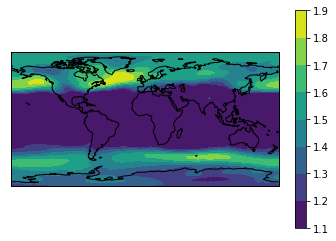

In [12]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
lat, lon = pv_anom['latitude'], pv_anom['longitude']
cs=ax.contourf(lon, lat, var_anom_thresh_arr*1e6)
plt.colorbar(cs)

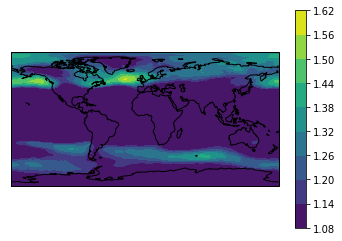

In [95]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
lat, lon = var_bool_tot['latitude'], var_bool_tot['longitude']
cs=ax.contourf(lon, lat, var_anom_thresh_arr*1e6)
plt.colorbar(cs)

In [142]:
var_anom_thresh_arr

<xarray.DataArray 'pv' (latitude: 181, longitude: 360)>
array([[1.277924e-06, 1.277924e-06, 1.277924e-06, ..., 1.277924e-06,
        1.277924e-06, 1.277924e-06],
       [1.263269e-06, 1.263145e-06, 1.263078e-06, ..., 1.262404e-06,
        1.262638e-06, 1.262926e-06],
       [1.244972e-06, 1.244569e-06, 1.244383e-06, ..., 1.244801e-06,
        1.244743e-06, 1.244756e-06],
       ...,
       [1.100000e-06, 1.100000e-06, 1.100000e-06, ..., 1.100000e-06,
        1.100000e-06, 1.100000e-06],
       [1.100000e-06, 1.100000e-06, 1.100000e-06, ..., 1.100000e-06,
        1.100000e-06, 1.100000e-06],
       [1.100000e-06, 1.100000e-06, 1.100000e-06, ..., 1.100000e-06,
        1.100000e-06, 1.100000e-06]])
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
    time       datetime64[ns] 1999-07-16T22:30:00

In [13]:
#create the boolean array showing the negative regions (anomalously low PV) - can take a few seconds to run
pv_day_bool_thresh = [pv_day < -var_anom_thresh_arr for pv_day in pv_anom[:]] 

In [25]:
pv_anom['latitude'], pv_anom['longitude']

(<xarray.DataArray 'latitude' (latitude: 181)>
 array([ 90.,  89.,  88.,  87.,  86.,  85.,  84.,  83.,  82.,  81.,  80.,  79.,
         78.,  77.,  76.,  75.,  74.,  73.,  72.,  71.,  70.,  69.,  68.,  67.,
         66.,  65.,  64.,  63.,  62.,  61.,  60.,  59.,  58.,  57.,  56.,  55.,
         54.,  53.,  52.,  51.,  50.,  49.,  48.,  47.,  46.,  45.,  44.,  43.,
         42.,  41.,  40.,  39.,  38.,  37.,  36.,  35.,  34.,  33.,  32.,  31.,
         30.,  29.,  28.,  27.,  26.,  25.,  24.,  23.,  22.,  21.,  20.,  19.,
         18.,  17.,  16.,  15.,  14.,  13.,  12.,  11.,  10.,   9.,   8.,   7.,
          6.,   5.,   4.,   3.,   2.,   1.,   0.,  -1.,  -2.,  -3.,  -4.,  -5.,
         -6.,  -7.,  -8.,  -9., -10., -11., -12., -13., -14., -15., -16., -17.,
        -18., -19., -20., -21., -22., -23., -24., -25., -26., -27., -28., -29.,
        -30., -31., -32., -33., -34., -35., -36., -37., -38., -39., -40., -41.,
        -42., -43., -44., -45., -46., -47., -48., -49., -50., -51., -52.,

In [28]:
pv_day_bool_thresh[0].values
#pv_anom['time']
arr=np.zeros((181,360))
for i in range(2):#14965
    pv_arr=np.concatenate((arr, pv_day_bool_thresh[i].values), axis=0)
    



In [39]:
pv_day_bool_thresh_npstack = np.stack([pv_day_bool_thresh[i].values for i in range(14965)])

In [44]:
pv_anom['time'].shape, pv_anom['latitude'].shape, pv_anom['longitude'].shape

((14965,), (181,), (360,))

In [40]:
pv_day_bool_thresh_npstack.shape

(14965, 181, 360)

In [36]:
pv_day_bool_thresh_autocomb = xr.merge(pv_day_bool_thresh[:5])

MergeError: conflicting values for variable 'pv' on objects to be combined:
first value: <xarray.Variable (latitude: 181, longitude: 360)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
second value: <xarray.Variable (latitude: 181, longitude: 360)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [18]:
#concatenate the lists of boolean DataArray objects - also takes a few seconds
pv_day_bool_thresh_concat = xarray.concat(pv_day_bool_thresh)

/home/cmt3718/anaconda3/envs/odin/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'
  


ValueError: encountered unexpected variable 'time'

In [157]:
pv_day_bool_thresh_concat['time'] = pv_file['time']

In [42]:
 pv_anom['time']

<xarray.DataArray 'time' (time: 14965)>
array(['1979-01-01T10:30:00.000000000', '1979-01-02T10:30:00.000000000',
       '1979-01-03T10:30:00.000000000', ..., '2019-12-29T10:30:00.000000000',
       '2019-12-30T10:30:00.000000000', '2019-12-31T10:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    level    float64 ...
  * time     (time) datetime64[ns] 1979-01-01T10:30:00 ... 2019-12-31T10:30:00
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T

In [46]:
#define the attrs for the new xarray
pv_attrs = OrderedDict()
pv_attrs['units'] = 'm^2 s^-1 K kg^-1'
pv_attrs['long_name'] = 'Potential vorticity'
pv_attrs['level'] = 'vertically averaged 150-500hPa'
pv_attrs['anom'] = 'LTDM average following Pinheiro et al (2019)'
pv_attrs['dataset'] = 'era5'
pv_attrs['date_range'] = 'JJA 1979-2019'
pv_attrs['bool_thresh'] = 'True if value < -1.5*timstd or -1.1 PVU (whichever is smaller)'

pv_day_bool_thresh_concat=xarray.DataArray(pv_day_bool_thresh_npstack, coords=(pv_anom['time'], pv_anom['latitude'], pv_anom['longitude']), attrs=pv_attrs)
#pv_day_bool_thresh_concat.to_netcdf("/rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_tot_daymean_P19vertmean_LTDManom_bool.nc")

#pv_day_bool_thresh_concat.to_netcdf("/rds/general/project/carl_phd/live/carl/data/era5/day/pv/pv_JJA_era5_1979-2019_dayvertmean_1x1_150-500hPa_anom_bool.nc")

In [48]:
#pv_day_bool_thresh_concat

pv_day_bool_thresh_concat.to_netcdf("/rds/general/project/nowack_graven/live/carl/pv_era5/pv_1x1_150-500hPa_1979-2019_tot_daymean_P19vertmean_LTDManom_bool.nc")

In [158]:
pv_day_bool_thresh_concat['latitude'] = pv_file['latitude']
pv_day_bool_thresh_concat['longitude'] = pv_file['longitude']



# 3. Apply the area threshold
For both DG83 (500hPa geopotential height anomaly) and S04 (VPV anomaly).

Define the relevant ``var_bool`` file depending on what one is calculating, and then the functions

In [10]:
var_bool_tot = xarray.open_dataset("/rds/general/project/nowack_graven/live/carl/pv_era5/"
                                   "pv_1x1_150-500hPa_1979-2019_tot_daymean_P19vertmean_LTDManom_bool.nc")

In [11]:
var_bool_tot

<xarray.Dataset>
Dimensions:                        (latitude: 181, longitude: 360, time: 14965)
Coordinates:
  * time                           (time) datetime64[ns] 1979-01-01T10:30:00 ... 2019-12-31T10:30:00
  * latitude                       (latitude) float32 90.0 89.0 ... -89.0 -90.0
  * longitude                      (longitude) float32 0.0 1.0 ... 358.0 359.0
Data variables:
    __xarray_dataarray_variable__  (time, latitude, longitude) bool ...

In [12]:
#these files have already had the amplitude calculation applied
#var_bool = xarray.open_dataset("/rds/general/project/carl_phd/live/carl/data/era5/day/zg/
#500zg_JJA_era5_1979-2018_0000_EurAR5_anom_dtrnd_wrt_tas_DG83_area_weighted_varbool.nc")['500zg']
#select the total var_bool file and then select the region
#var_bool_tot = xarray.open_dataset("/rds/general/project/carl_phd/live/carl/data/era5/day/pv/"
#                "pv_JJA_era5_1979-2019_dayvertmean_1x1_150-500hPa_anom_bool.nc")['pv']

var_bool_tot = xarray.open_dataset("/rds/general/project/nowack_graven/live/carl/pv_era5/"
                                   "pv_1x1_150-500hPa_1979-2019_tot_daymean_P19vertmean_LTDManom_bool.nc")['__xarray_dataarray_variable__']

#pv_bool = xarray.open_dataset("/rds/general/project/carl_phd/live/carl/data/era5/day/pv/pv_JJA_era5_1979-2019_dayvertmean_1x1_150-500hPa_anom_bool.nc")['pv']

lats_arr, lons_arr = [30,75], [-10+180,40+180]#[-45+180,40+180]
lats = np.arange(lats_arr[0],lats_arr[1])
lons = np.arange(lons_arr[0],lons_arr[1])  
season = "JJA"
var_bool = var_bool_tot.sel(latitude = np.isin(var_bool_tot['latitude'], lats), 
                              longitude = np.isin(var_bool_tot['longitude'], lons),
                              #time = np.isin(var_bool_tot['time.season'], season)
                            )#time = np.isin(var_bool_tot['time.year'], year_arr),

time, lat, lon = var_bool['time'], var_bool['latitude'], var_bool['longitude']
#pv_JJA_era5_1979-2019_dayvertmean_1x1_150-500hPa_anom_bool_EurAR5.nc


In [13]:
var_bool

<xarray.DataArray '__xarray_dataarray_variable__' (time: 14965, latitude: 45, longitude: 50)>
[33671250 values with dtype=bool]
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T10:30:00 ... 2019-12-31T10:30:00
  * latitude   (latitude) float32 74.0 73.0 72.0 71.0 ... 33.0 32.0 31.0 30.0
  * longitude  (longitude) float32 170.0 171.0 172.0 173.0 ... 217.0 218.0 219.0
Attributes:
    units:        m^2 s^-1 K kg^-1
    long_name:    Potential vorticity
    level:        vertically averaged 150-500hPa
    anom:         LTDM average following Pinheiro et al (2019)
    dataset:      era5
    date_range:   JJA 1979-2019
    bool_thresh:  True if value < -1.5*timstd or -1.1 PVU (whichever is smaller)

In [14]:
def len_iter(items):
    return sum(1 for _ in items)

def consecutive_one(data):
    return max(len_iter(run) for val, run in groupby(data) if val)

In [15]:
def LatLon_To_XY(Lat,Lon):
    return np.array(P(Lat,Lon)) 

In [16]:
#convert lat and lon coordinates of polygon to calculate polygon area
#from https://gis.stackexchange.com/questions/298929/converting-lat-lon-to-x-y-coordinates-with-pyproj
#alternative solution: https://stackoverflow.com/questions/4681737/how-to-calculate-the-area-of-a-polygon-on-the-earths-surface-using-python/4682656#4682656
P = pyproj.Proj(proj='utm', zone=31, ellps='WGS84', preserve_units=True)
G = pyproj.Geod(ellps='WGS84')

def LatLon_To_XY(Lat,Lon):
    return np.array(P(Lat,Lon))    

def XY_To_LatLon(x,y):
    return P(x,y,inverse=True)    

def distance(Lat1, Lon1, Lat2, Lon2):
    return G.inv(Lon1, Lat1, Lon2, Lat2)[2]

def area_of_polygon(x, y):
    """Calculates the area of an arbitrary polygon given its verticies"""
    area = 0.0
    for i in range(-1, len(x)-1):
        area += x[i] * (y[i+1] - y[i-1])
    return abs(area) / 2.0

In [17]:
#adapted from https://gis.stackexchange.com/questions/99917/converting-matplotlib-contour-objects-to-shapely-objects
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx+1

def area_test(var_bool, lat, lon, grid_coords, area_thresh, prop_blocked_thresh, min_num_grid_cells):
    """
    Calculate the polygon shapes, determine the area for the blocked polygons and if there is a
    blocked polygon identify whether or not it passes the area_thresh threshold
    if so, then day is blocked
    """
    blocked_day = 0
    prop_blocked = np.array(np.where(var_bool == 1)).shape[1]/(len(lat)*len(lon))
    if prop_blocked < prop_blocked_thresh:
        return blocked_day, [[0]]
    #test if there are two few blocked grid cells that we know there cannot be blocking
    CS = plt.contour(lon,lat,var_bool)
    plt.close()
    #print(f"var_bool.shape = {var_bool.shape}")
    var_bool_blocked_idx = np.zeros((len(lat)*len(lon)))#use to identify blocked regions    
    for col in CS.collections:
        # Loop through all polygons that have the same intensity level
        for contour_path in col.get_paths():
            # Create the polygon for this intensity level
            # The first polygon in the path is the main one, the following ones are "holes"
            for ncp,cp in enumerate(contour_path.to_polygons()):
                try:
                    x = cp[:,0]
                    y = cp[:,1]
                except TypeError: #when the data is stored as a list of arrays
                    x = [arr[0] for arr in cp]
                    y = [arr[1] for arr in cp]
                new_shape = geometry.Polygon([(i[0], i[1]) for i in zip(x,y)])
                if ncp == 0:
                    poly = new_shape
                else:
                    # Remove the holes if there are any
                    print("Holes")
                    poly = poly.difference(new_shape)
                    # Can also be left out if you want to include all rings
                # do something with polygon
                # Extract the point values that define the perimeter of the polygon
                lon_shape, lat_shape = poly.exterior.coords.xy
                #make a path object for the polygon
                tup_verts = list(zip(lat_shape, lon_shape))
                p = Path(tup_verts) # make a polygon
                points = grid_coords
                grid = p.contains_points(points)
                #print(f"grid = {sum(grid)}")
                #print(f"grid.shape = {grid.shape}")                
                mask = grid.reshape(len(lat),len(lon))# now you have a mask with points inside a polygon            
                num_grid_cells_blocked_in_poly = sum(grid)
                
                if num_grid_cells_blocked_in_poly > min_num_grid_cells:
                    #blocked region potentially large enough to qualify as blocking
                    #calculate area of polygon by converting from lat,lon coordinates to x, y coordinates
                    #print(f"lon_shape = {lon_shape}")                    
                    lon_shape = [lon - 180 for lon in lon_shape] #convert for longitude coordinates
                    #print(f"lon_shape = {lon_shape}")
                    #print(f"y = {y}")
                    x, y = LatLon_To_XY(lat_shape,lon_shape)
                    #print(f"x, y = {lat_shape, lon_shape}")                    
                    area = geometry.Polygon(list(zip(x, y))).area
                    #print(f"x, y = {x, y}")
                    #covnert from m^2 to km^2
                    area_km = area/1e6
                    if area_km > area_thresh:
                        #label day as blocked
                        blocked_day = 1
                        #relabel cells in blocked polygon for testing the overlap critereon
                        var_bool_blocked_idx += grid #add the array to a 1d level
    #return if the day is blocked and the flattened index values of the blocked tiles for the overlap test
    return blocked_day, np.where(var_bool_blocked_idx > 0)



In [18]:
#these variables can be modified
area_thresh = 1e6 # minimum blocked area in km^2
# 1e6 km^2 is a reasonable minimum area since this is approximately the squared radius of a typical anticyclone (pg 10 of Hoskins & James)
grid_res = 1 #grid resolution
#create a tuple of the lat/lon coordinates of the grid to test whether or not the grid cells exist within the point
lats, lons = np.asarray(np.meshgrid(lat,lon))[0,:,:].flatten(), np.asarray(np.meshgrid(lat,lon))[1,:,:].flatten()
grid_coords = list(zip(lats,lons))
#rough minimum for the number of grid cells needed for a blocking event
min_num_grid_cells=area_thresh*np.cos(np.radians(30))/(grid_res*grid_res*110*110) #0.25x0.25 grid x 110km (roughly 1/360 of Earth's circumference)
#minimum proportion of grid cells to block
prop_blocked_thresh = min_num_grid_cells/(len(lat)*len(lon))

In [20]:
#note that for this dataset this cell takes a long time (several minutes) to run
lat = var_bool['latitude']
lon = var_bool['longitude']
time = var_bool['time']
blocked_day_arr = []

#mv /rds/general/project/carl_phd/live/carl/data/era5/day/vpv/block_data/*newresdaymean* 
#/rds/general/project/carl_phd/live/carl/data/era5/day/zg/block_data/
#save the block_arr_area and blocked_idx_vals files
#this gives information about the index values that are blocked on that day, which will be used when applying the overlap threshold
with open(f"/rds/general/project/carl_phd/live/carl/data/era5/day/vpv/block_data/blocked_day/LTDMcorr/allyr/blocked_day_arr_allyr_nolp.txt", "a+") as blocked_day_arr_tot:
    for i in range(0,len(time)):
        if i%100 == 0:
            print(i)
        blocked_day, var_bool_blocked = area_test(var_bool[i,:,:], lat, lon, grid_coords, area_thresh, prop_blocked_thresh, min_num_grid_cells)
        #the block_data files saves the data for each day for the particular indices that are blocked
        np.savetxt(f"/rds/general/project/carl_phd/live/carl/data/era5/day/vpv/block_data/LTDMcorr/allyr/blocked_idx_vals_%04d_2.txt"%i, var_bool_blocked[0])        
        blocked_day_arr_tot.write("%s "%blocked_day)
        
blocked_day_arr_tot.close()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900


In [22]:
blocked_day_arr_tot = np.loadtxt("/rds/general/project/carl_phd/live/carl/data/era5/day/vpv/block_data/blocked_day/blocked_day_arr_tot_newresdaymean_fixed.txt")

blocked_day_arr_tot = np.loadtxt("/rds/general/project/carl_phd/live/carl/data/era5/day/vpv/block_data/blocked_day/LTDMcorr/allyr/blocked_day_arr_allyr_nolp.txt")


In [23]:
len(blocked_day_arr_tot)

14965

In [26]:
sum(blocked_day_arr_tot)/len(blocked_day_arr_tot)

0.3646508519879719

In [141]:
sum(blocked_day_arr_tot)/len(blocked_day_arr_tot)

0.5045068928950159

# 4. Apply the persistence criterea
This is defined and then applied both before and after the overlap criterea

In [27]:
def search_sequence_numpy(arr,seq):
    """ Find sequence in an array using NumPy only.

    Parameters
    ----------    
    arr    : input 1D array
    seq    : input 1D array

    Output
    ------    
    Output : 1D Array of indices in the input array that satisfy the 
    matching of input sequence in the input array.
    In case of no match, an empty list is returned.
    """

    # Store sizes of input array and sequence
    Na, Nseq = len(arr), len(seq)

    # Range of sequence
    r_seq = np.arange(Nseq)

    # Create a 2D array of sliding indices across the entire length of input array.
    # Match up with the input sequence & get the matching starting indices.
    M = (arr[np.arange(Na-Nseq+1)[:,None] + r_seq] == seq).all(1)

    # Get the range of those indices as final output
    if M.any() >0:
        return np.where(np.convolve(M,np.ones((Nseq),dtype=int))>0)[0]
    else:
        return []         # No match found


In [33]:
#to apply the persstence critereon, need to remove all events that don't persist over a period of five days
#any sequence of 1,1,1,1,1 or more is fine, but 0,1,1,1,1,0 or less must be removed
#sequences to be removed: 0,1,1,1,1,0; 0,1,1,1,0; 0,1,1,0; 0,1,0
#note that Verdecchia et al (1996) add some criterea for blocking to be removed
def persistence_criterea_allyr(block_arr, persis_thresh, JJA_days):
    """
    Apply the persistence criterea to a list of days which are blocked or not
    by removing the sequences for days which are not blocked
    persis_thresh is the minimum number of blocked days for the threshold (at least 2)
    block_arr is an array of True/False days of blocking
    This is for when calculating blocking to occur all year round, so there is no need to apply padding to the array
    """
    block_arr_persis=block_arr.copy()
    #blocking sequences to be removed
    seq_arr = [[0,1,0], [0,1,1,0], [0,1,1,1,0], [0,1,1,1,1,0], [0,1,1,1,1,1,0]]
    seq_to_remove_arr = seq_arr[:persis_thresh-1]
    
    for seq in seq_to_remove_arr:
        seq_idx=search_sequence_numpy(block_arr_persis,seq)
        block_arr_persis[seq_idx] = 0
    return block_arr_persis

In [29]:
#to apply the persstence critereon, need to remove all events that don't persist over a period of five days
#any sequence of 1,1,1,1,1 or more is fine, but 0,1,1,1,1,0 or less must be removed
#sequences to be removed: 0,1,1,1,1,0; 0,1,1,1,0; 0,1,1,0; 0,1,0
#note that Verdecchia et al (1996) add some criterea for blocking to be removed
def persistence_criterea(block_arr, persis_thresh, JJA_days):
    """
    Apply the persistence criterea to a list of days which are blocked or not
    by removing the sequences for days which are not blocked
    persis_thresh is the minimum number of blocked days for the threshold (at least 2)
    block_arr is an array of True/False days of blocking
    NB removes when blocking occurs briefly at the start or end of a season
    Assume that blocking at the end of August doesn't persist into early September
    and that there was no blocking late May. This would be a sensible approximation to apply
    since we are only here interested in JJA blocking events.
    """
    #pad the array to remove any erroneous blocking events that would coincide from the end of the season to the start of the next
    block_arr_pad = block_arr.copy()
    #to add elements to an array, add from reverse so that the index numbering doesn't mess up
    idx_arr = np.arange(JJA_days, block_arr.shape[0], JJA_days)[::-1]

    for i in idx_arr:
        block_arr_pad = np.concatenate((block_arr_pad[:i], [0], block_arr_pad[i:]))
        
    block_arr_persis=block_arr.copy()
    #blocking sequences to be removed
    seq_arr = [[0,1,0], [0,1,1,0], [0,1,1,1,0], [0,1,1,1,1,0], [0,1,1,1,1,1,0]]
    seq_to_remove_arr = seq_arr[:persis_thresh-1]
    

    block_arr_pad_persis=block_arr_pad.copy()
    for seq in seq_to_remove_arr:
        seq_idx=search_sequence_numpy(block_arr_pad_persis,seq)
        block_arr_pad_persis[seq_idx] = 0
    # then need to remove the padding from the array
    #indices to be removed - note the shift of the index ordering
    added_idx = np.arange(JJA_days, block_arr.shape[0], JJA_days+1)
    block_arr_persis = np.delete(block_arr_pad_persis, added_idx)
    return block_arr_persis

In [34]:
#apply persistence criterea
#this seems to remove half of all blocking events and can take a few minutes to run
blocked_day_arr_persis = persistence_criterea_allyr(np.array(blocked_day_arr_tot), persis_thresh, JJA_days)

In [45]:
len(blocked_day_arr_persis) 

14965

In [35]:
sum(blocked_day_arr_persis)/len(blocked_day_arr_persis) 

0.19819579017707986

# 5. Apply the overlap criterea

In [36]:
def calc_blocked_overlap_across_period(blocked_idx_vals, overlap_val):
    """
    Calculate the number of tiles blocked across period
    """
    blocked_idx_across_period = []
    for num_days, blocked_idx_day in enumerate(blocked_idx_vals):
        blocked_idx_across_period = np.append(blocked_idx_across_period, blocked_idx_day)
    #count the number of elements that occur num_days+1 times
    blocked_idx_unique, return_counts_arr = np.unique(blocked_idx_across_period, return_counts=True)
    blocked_across_period = len([j for i,j in enumerate(blocked_idx_unique) if return_counts_arr[i] > num_days])
    return blocked_across_period

def array_subsampled(arr, i):
    """
    Return consecutive samples of an array
    """
    arr_list = []
    
    #there are i numbers of array
    for j in range(i+1):
        #0:len(arr)-i, 1:len(arr)-i+1, ... , i-1:len(arr)-1, i:len(arr)
        arr_list = np.append(arr_list, arr[0+j:len(arr)-i+j])
    return arr_list

In [37]:
#potentially helpful: https://stackoverflow.com/questions/55641425/check-if-two-contours-intersect
def overlap_contour_criterea(blocked_idx_vals, block_arr, persis_thresh, JJA_days, overlap_val):
    """
    To calculate the overlap criterea, need contour overlap over the five day period
    For each five day period, need contour overlap
    for the region to remain blocked over that five day period.
    """
    #block_arr = block_arr_orig.copy() #change back when not testing
    for i, blocked in enumerate(block_arr):
        # measure if the previous day was blocked
        if i == 0: 
            prev_blocked = 0
        else:
            prev_blocked = block_arr[i-1]
        if blocked == 1 and prev_blocked == 0: #if a new blocking event is starting
            #measure the length of the blocked event (in days) by finding the first zero element after the first zero element
            blocked_arr_samp = block_arr[i:]
            length_of_block = next((index for index,value in enumerate(blocked_arr_samp) if value != 1), 0)
            #need to sample periods of persis_thresh within this blocked period
            #and test whether or not the contours overlap, that is whether or not a certain percentage of the
            #indices of the blocked longitudes are identical
            for k in range(i,i+length_of_block-persis_thresh+1):#loop within the blocked period across the minumum persistence criterea
                #since the shorter periods have been removed, blocked_idx_arr shows the indices of all of the blocked zones on each day
                #within the minimum time period
                #blocked_idx_vals is a 1d list for the blocked indices
                #calculate the number of tiles blocked across the period
                blocked_across_period = calc_blocked_overlap_across_period(blocked_idx_vals[k:k+persis_thresh], overlap_val)
                #if the number of blocked cells is less than the number of overlapping cells
                #then there isn't a contour overlap across the five day period
                #so need to find where the discontinuity takes place within this time period
                if blocked_across_period < overlap_val:
                    while blocked_across_period < overlap_val:
                        for l in range(1, persis_thresh-1):
                        #subselect periods of blocked days to find at what point the deviation occurs
                        #and then eliminate previous day as a block
                            blocked_idx_vals_subsamp_list = array_subsampled(blocked_idx_vals[k:k+persis_thresh-1], l)
                            try:
                                for m, blocked_idx_vals_subsamp in enumerate(blocked_idx_vals_subsamp_list):
                                    block_arr[l+k-1+m] = 0
                                    #when there is only one value in blocked_idx_vals_subsamp
                                    #eliminate previous day as a block for each time when there isn't a block calculated across the period     
                                    blocked_across_period = calc_blocked_overlap_across_period(blocked_idx_vals_subsamp, overlap_val)
                            except TypeError: #exception when there is only one list
                                    block_arr[l+k-1] = 0
                                    blocked_across_period = calc_blocked_overlap_across_period(blocked_idx_vals_subsamp_list, overlap_val)
                        blocked_across_period = overlap_val # to get out of the while loop if needed (at this point no overlap has been identified)
    return block_arr

In [38]:
blocked_idx_vals_list = sorted(glob.glob("/rds/general/project/carl_phd/live/carl/data/era5/day/vpv/block_data/LTDMcorr/allyr/*"))

In [6]:

for i in [0,1,2,3,4,5,6,7,8,9]:
    print(f"rm -f *{i}2.txt* &")
    

rm -f *02.txt* &
rm -f *12.txt* &
rm -f *22.txt* &
rm -f *32.txt* &
rm -f *42.txt* &
rm -f *52.txt* &
rm -f *62.txt* &
rm -f *72.txt* &
rm -f *82.txt* &
rm -f *92.txt* &


In [39]:
blocked_idx_vals_list = sorted(glob.glob("/rds/general/project/carl_phd/live/carl/data/era5/day/vpv/block_data/*_fixed.txt*"))#_fixed.txt
blocked_idx_vals_list = sorted(glob.glob("/rds/general/project/carl_phd/live/carl/data/era5/day/vpv/block_data/LTDMcorr/*_2.txt*"))

blocked_idx_vals_list = sorted(glob.glob("/rds/general/project/carl_phd/live/carl/data/era5/day/vpv/block_data/LTDMcorr/allyr/*"))

#can ignore errors here, since expcetion where there are no elements in the file is handled in the overlap function
import warnings
warnings.simplefilter('ignore')
#load the values for the indices of blocked days to use in the overlap calculation - takes a few seconds
blocked_idx_vals = [np.loadtxt(blocked_idx_val) for blocked_idx_val in blocked_idx_vals_list]

In [40]:
#calculate overlap - usually takes a few seconds
blocked_day_arr_persis_overlap = overlap_contour_criterea(blocked_idx_vals, blocked_day_arr_persis, persis_thresh, JJA_days, overlap_val)

In [47]:
#run the persistence threshold again to remove any blocking events that now no longer pass the persistence criterea
blocked_day_arr_persis_overlap_persis = persistence_criterea_allyr(np.array(blocked_day_arr_persis_overlap), persis_thresh, JJA_days)

In [48]:
sum(blocked_day_arr_persis_overlap_persis)/len(blocked_day_arr_persis_overlap_persis)

0.04350150350818577

In [51]:
np.savetxt("/rds/general/user/cmt3718/home/data/S04_idx/S04_idx_block_arr_era5_daymean_LTDMavg_allyrnolp.txt", blocked_day_arr_persis_overlap_persis)

In [52]:
sum(blocked_day_arr_persis_overlap_persis)

651.0

In [50]:
len(blocked_day_arr_persis_overlap_persis)

14965

## Test the difference between the old and new blocking indices

TM90 isn't changed, but the DG83 and S04 indices which rely on the naomaly have been changed. See what the days are that were not accounted for in the new data

In [38]:
TM90 = np.loadtxt("/rds/general/user/cmt3718/home/data/TM90_blocked_arr/TM90_arr_Delta2_timeseries_era5_reanal_1979-2019_JJA_daymean.txt")
DG83_LTDM = np.loadtxt("/rds/general/user/cmt3718/home/data/DG83_idx/DG83_idx_block_arr_era5_daymean_LTDM.txt")
DG83_orig = np.loadtxt("/rds/general/user/cmt3718/home/data/DG83_idx/DG83_idx_block_arr_era5_daymean.txt")
S04_orig = np.loadtxt("/rds/general/user/cmt3718/home/data/S04_idx/S04_idx_block_arr_era5_daymean.txt")
S04_LTDM = np.loadtxt("/rds/general/user/cmt3718/home/data/S04_idx/S04_idx_block_arr_era5_daymean_LTDMavg.txt")

In [39]:
tot_old = TM90+DG83_orig+S04_orig
tot_new = TM90+DG83_LTDM+S04_LTDM

In [46]:
one_block_old = np.array([1 if val > 0 else 0 for val in tot_old])
one_block_new = np.array([1 if val > 0 else 0 for val in tot_new])



In [81]:
one_block, two_block = (np.zeros(one_block_old.shape), np.zeros(one_block_old.shape))

one_block[np.where(one_block_old+one_block_new == 1)[0]] = 1

two_block[np.where(one_block_old+one_block_new == 2)[0]] = 1

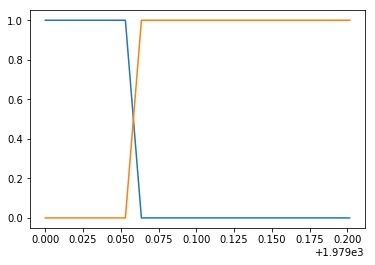

In [97]:
matching_blo, matching_notblo, matching_incon = (np.zeros(one_block_old.shape), np.zeros(one_block_old.shape), np.zeros(one_block_old.shape))
#identify the events that don't need to have any changed classification
#list the index positions for the matching blocked events and matching not blocked events
matching_blo[np.where(one_block_old+one_block_new == 2)[0]] = 1

matching_notblo[np.where(one_block_old+one_block_new == 0)[0]] = 1

matching_incon[np.where(one_block_old+one_block_new == 1)[0]] = 1

#matching_blo = np.where(one_block_old+one_block_new == 2)[0]
#matching_notblo = np.where(one_block_old+one_block_new == 0)[0]
#the events that don't need to be changed are those for which there is no difference between the two different indices#
#and there is no difference for the surrounding index notation

#that is, where when matching_blo = 1 and matching_notblo = 1 have no zero value between them
#for idx, blo in enumerate(matching_blo):
    
#    print(f"blo = {blo}")


samp = 20
plt.plot(x[:20], matching_blo[:samp])
plt.plot(x[:samp], matching_notblo[:samp])



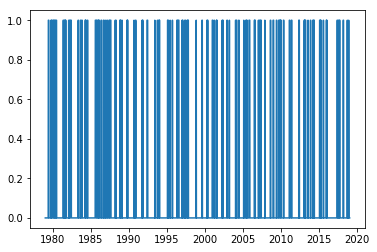

In [99]:
plt.plot(x, matching_incon)

In [100]:
not_matched=np.where(matching_blo+matching_notblo == 0)[0] #list of values of gaps where the sets of blocked indices are not matched
#the blocked events that don't need to be changed are the events where there is no change for the event for the edges of the event


In [ ]:
#events to change:

[37,38,39,40,41,42,43,
 71,72,73,74,75,81,82,83,84,85,86,87

]

#don't change:
[0,1,2,3,4,5,

]

In [104]:
np.where(one_block_new == 1)[0]

array([   0,    1,    2,    3,    4,    5,   71,   72,   73,   74,   75,
         81,   82,   83,   84,   85,   86,   87,   93,   94,   95,   96,
         97,   98,   99,  100,  121,  122,  123,  124,  125,  135,  136,
        137,  138,  139,  202,  203,  204,  205,  206,  207,  208,  209,
        210,  211,  212,  213,  214,  215,  216,  217,  221,  222,  223,
        224,  225,  248,  249,  250,  251,  252,  276,  277,  278,  279,
        280,  281,  282,  283,  284,  291,  292,  293,  294,  295,  296,
        297,  298,  299,  300,  301,  329,  330,  331,  332,  333,  334,
        335,  336,  337,  338,  339,  340,  341,  373,  374,  375,  376,
        377,  446,  447,  448,  449,  450,  451,  493,  494,  495,  496,
        497,  498,  499,  521,  522,  523,  524,  525,  544,  545,  546,
        547,  548,  580,  581,  582,  583,  584,  585,  619,  620,  621,
        622,  623,  624,  625,  626,  627,  628,  629,  638,  639,  640,
        641,  642,  643,  656,  657,  658,  659,  6

In [103]:
np.where(one_block_old+one_block_new == 2)[0]

array([   0,    1,    2,    3,    4,    5,   72,   73,   74,   75,   81,
         82,   83,   84,   85,   86,   87,  202,  203,  204,  205,  206,
        207,  208,  209,  210,  211,  212,  213,  214,  215,  216,  217,
        248,  249,  250,  251,  252,  276,  277,  278,  279,  280,  281,
        282,  283,  284,  291,  292,  293,  294,  295,  296,  297,  298,
        299,  300,  301,  329,  330,  331,  332,  333,  334,  335,  336,
        337,  338,  339,  340,  341,  373,  374,  375,  376,  377,  446,
        447,  448,  449,  450,  499,  544,  545,  546,  547,  548,  580,
        581,  582,  583,  584,  585,  668,  669,  670,  671,  672,  673,
        674,  675,  743,  744,  745,  746,  747,  748,  749,  750,  751,
        752,  813,  814,  815,  816,  817,  818,  819,  820,  821,  822,
        823,  824,  825,  826,  827,  862,  863,  864,  865,  866,  872,
        873,  874,  875,  876,  936,  937,  938,  939,  940,  952,  953,
        954,  955,  956,  957,  958,  959,  960, 10

In [91]:
matching_blo[:samp]

array([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [92]:
matching_notblo[:samp]

array([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

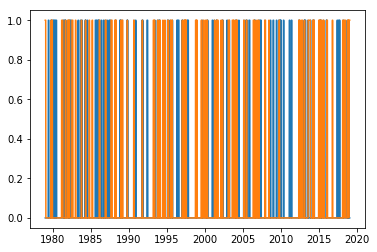

In [82]:
plt.plot(x, one_block)
plt.plot(x, two_block)
#one_block, two_block

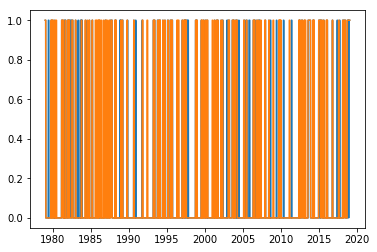

In [68]:
x = np.linspace(1979,2019,one_block_new.shape[0])
plt.plot(x, one_block_old)
plt.plot(x, one_block_new)

In [66]:
one_block_old

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
np.where(DG83_orig[:] == DG83_LTDM[:])

In [64]:
sum(TM90alt), sum(TM90)

(263.0, 263.0)

In [ ]:
block_arr_sum = TM90_idx + S04_idx + DG83_idx